In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from facenet_pytorch import MTCNN
import torch

from dataset import FacialLandmarkDataset

In [3]:
dataset = FacialLandmarkDataset(root_dir='archive/ibug_300W_large_face_landmark_dataset/afw')

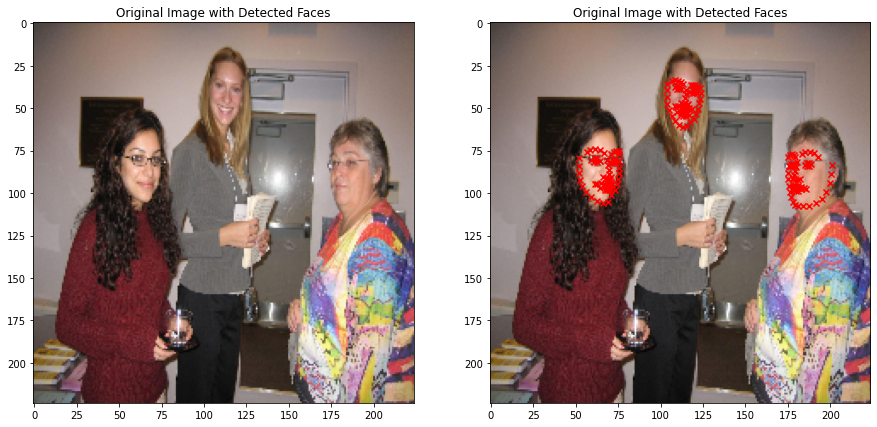

3


In [7]:
img, landmark_list = dataset.__getitem__(2)

# Plot the original image with bounding boxes
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Detected Faces')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
for landmarks in landmark_list:
    plt.scatter(landmarks[:, 0], landmarks[:, 1], c='r', marker='x')
plt.title('Original Image with Detected Faces')

plt.show()

print(len(landmark_list))

In [10]:
print(len(landmark_list[0]))
print(len(landmark_list[1]))
print(len(landmark_list[2]))

68
68
68
